In [3]:
%%capture
!pip install wget
!pip install transformers

In [4]:
import wget
import os
import pandas as pd
import numpy as np
import time
import datetime
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import matthews_corrcoef

import torch
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

device = torch.device("cuda")

### Loading the CoLA Dataset

#### Downloading the Data

In [6]:
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

#### Loading the Data

In [7]:
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

print('Number of training sentences: {:,}\n'.format(df.shape[0]))

Number of training sentences: 8,551



In [8]:
df.sample(10)

,sentence_source,label,label_notes,sentence
2345,l-93,1,NaN,Ida hunted deer in the woods.
2809,l-93,0,*,Paula swatted the cloth through the fly.
8299,ad03,0,*,Jason whispered the phoenix had escaped
3296,l-93,1,NaN,A fire raged all through the mountains.
4367,ks08,1,NaN,We persuaded the dentist to examine us.
5350,b_73,0,*,A tangerine isn't as much different from an or...
2452,l-93,1,NaN,A little boy ran in the yard.
880,bc01,0,??,Ron wanted to be wearing a tuxedo to the party...
4270,ks08,0,*,It hopes to bother Kim that they resigned.
2742,l-93,0,*,Carmen bought a dress to Mary.


In [9]:
df.loc[df.label == 0].sample(5)[['sentence', 'label']]

sentences = df.sentence.values
labels = df.label.values

### Tokenizing the sentences

In [10]:
# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [11]:
print(' Original: ', sentences[0])

 Original:  Our friends won't buy this analysis, let alone the next one we propose.


In [12]:
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']


In [13]:
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


#### Adding [CLS] & [SEP] tokens

In [14]:
max_len = 0
for sent in sentences:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  47


In [18]:
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


### Generating Tensor Dataset

In [19]:
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,695 training samples
  856 validation samples


In [21]:
batch_size = 32

train_dataloader = DataLoader(train_dataset,
                              sampler = RandomSampler(train_dataset),
                              batch_size = batch_size)

validation_dataloader = DataLoader(val_dataset,
                                   sampler = SequentialSampler(val_dataset),
                                   batch_size = batch_size)

### Loading the *model*

In [22]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                      num_labels = 2,
                                                      output_attentions = False,
                                                      output_hidden_states = False,)


model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

#### Model Parameters

In [23]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

The BERT model has 201 different named parameters.



##### Embedding Layer

In [24]:
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)


##### First Transformer

In [25]:
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (768,)
bert.encoder.layer.0.attention.output.LayerNorm.weight        (768,)
bert.encoder.layer.0.attention.output.LayerNorm.bias          (768,)
bert.encoder.layer.0.intermediate.dense.weight           (3072, 768)
bert.encoder.layer.0.intermediate.dense.bias                 (3072,)
bert.encoder.layer.0.output.dense.weight                 (768, 3072)
bert.encoder.layer.0.output.dense.bias                        (768,)
bert.encoder.layer.0.output.LayerN

##### Output Layer

In [26]:
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

bert.pooler.dense.weight                                  (768, 768)
bert.pooler.dense.bias                                        (768,)
classifier.weight                                           (2, 768)
classifier.bias                                                 (2,)


#### Setting up the Optimizer

In [27]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8)

### Training the model

#### Learning Rate Scheduler

In [28]:
epochs = 4
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

#### Custom accuracy metric

In [29]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [30]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

#### Training

In [37]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('\n======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))

    t0 = time.time()

    total_train_loss = 0
    
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels).values()
        
        total_train_loss += loss.item()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    print("\nValidation\n")

    t0 = time.time()

    model.eval()
    
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():       
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels).values()
            
        total_eval_loss += loss.item()
        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append({'epoch': epoch_i + 1,
                           'Training Loss': avg_train_loss,
                           'Valid. Loss': avg_val_loss,
                           'Valid. Accur.': avg_val_accuracy,
                           'Training Time': training_time,
                           'Validation Time': validation_time})     

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))                      


======== Epoch 1 / 4 ========
  Batch    40  of    241.    Elapsed: 0:00:09.
  Batch    80  of    241.    Elapsed: 0:00:17.
  Batch   120  of    241.    Elapsed: 0:00:26.
  Batch   160  of    241.    Elapsed: 0:00:34.
  Batch   200  of    241.    Elapsed: 0:00:42.
  Batch   240  of    241.    Elapsed: 0:00:51.

  Average training loss: 0.22
  Training epcoh took: 0:00:51

Validation

  Accuracy: 0.82
  Validation Loss: 0.52
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
  Batch    40  of    241.    Elapsed: 0:00:08.
  Batch    80  of    241.    Elapsed: 0:00:17.
  Batch   120  of    241.    Elapsed: 0:00:26.
  Batch   160  of    241.    Elapsed: 0:00:34.
  Batch   200  of    241.    Elapsed: 0:00:43.
  Batch   240  of    241.    Elapsed: 0:00:51.

  Average training loss: 0.22
  Training epcoh took: 0:00:51

Validation

  Accuracy: 0.82
  Validation Loss: 0.50
  Validation took: 0:00:02

======== Epoch 3 / 4 ========
  Batch    40  of    241.    Elapsed: 0:00:09.
  Batch   

#### Training statistics

In [38]:
pd.set_option('precision', 2)

df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.22,0.52,0.82,0:00:51,0:00:02
2,0.22,0.50,0.82,0:00:51,0:00:02
3,0.15,0.59,0.82,0:00:51,0:00:02
4,0.13,0.59,0.82,0:00:51,0:00:02


#### Training & Validation Loss plot

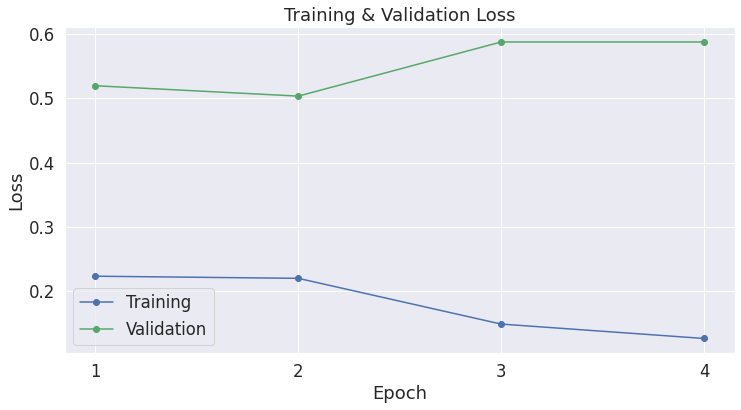

In [39]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## Testing the model

### Loading and formatting the test data

In [40]:
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

print('Number of test sentences: {:,}\n'.format(df.shape[0]))

Number of test sentences: 516



### Tokenizing the test data

In [41]:
sentences = df.sentence.values
labels = df.label.values

input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(sent,
                                         add_special_tokens = True,
                                         max_length = 64,
                                         pad_to_max_length = True,
                                         return_attention_mask = True,
                                         return_tensors = 'pt',)
     
    input_ids.append(encoded_dict['input_ids'])

    attention_masks.append(encoded_dict['attention_mask'])


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


### Generating Tensor dataset

In [42]:
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

In [43]:
batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

### Generating Predictions

In [49]:
model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:

  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch
  
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

#### Computing the Mathews Correlation Coefficient (MCC)

In [45]:
matthews_set = []

for i in range(len(true_labels)):

  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

flat_predictions = np.concatenate(predictions, axis=0)

flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

flat_true_labels = np.concatenate(true_labels, axis=0)

mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.530


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


##### MCC per batch

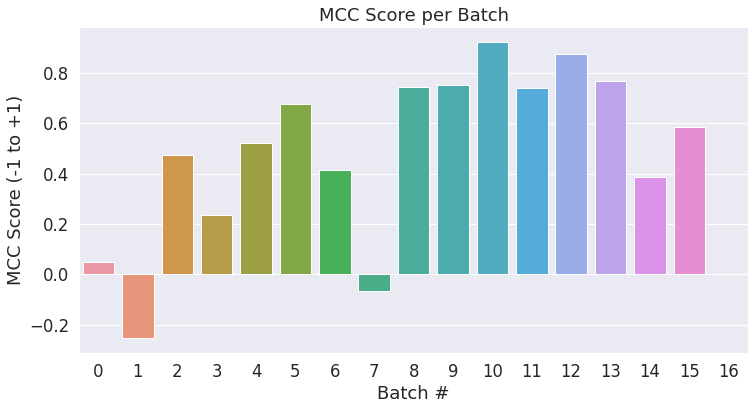

In [46]:
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

### Saving the model

In [47]:
output_dir = './model_save/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model  
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

### Loading the stored model

In [ ]:
model = model_class.from_pretrained(output_dir)
tokenizer = tokenizer_class.from_pretrained(output_dir)

model.to(device)